In [1]:
import iflai
import matplotlib.pyplot as plt
import iflai.ml.Features as Features
from iflai.ml.AutoFeatureSelection import AutoFeatureSelection
from iflai.ml.FeatureExtractor import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from iflai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [2]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print("sklearn report", "\n")
    print(classification_report(y_true, y_pred))
    print("\n", "imblanaced report", "\n")
    print(classification_report_imbalanced(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

In [3]:
data_path = "/pstore/data/DS4/White_blood_cell_dataset/"

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", Features.MaskBasedFeatures()), 
                                ("GLCMFeatures", Features.GLCMFeatures()),  
                                ("GradientRMS", Features.GradientRMS()),  
                                ("BackgroundMean", Features.BackgroundMean()),  
                                ("CellShape", Features.CellShape()),  
                                ("Collocalization", Features.Collocalization())
                                     ],
                                n_jobs = -1)
feature_extractor = FeatureExtractor(feature_union)

In [4]:
%time

metadata = iflai.metadata_generator(data_path)

  0%|          | 0/31280 [00:00<?, ?it/s]

CPU times: user 3 µs, sys: 4 µs, total: 7 µs
Wall time: 16 µs
Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:05<00:00, 6166.07it/s]


...metadata prepration ended.


In [5]:
indx = metadata["label"] != "unknown"
metadata = metadata.loc[indx,:]

In [6]:
metadata = metadata.reset_index(drop = True)

In [7]:
df_features = feature_extractor.extract_features(metadata)

100%|██████████| 29994/29994 [05:18<00:00, 94.21it/s] 


In [8]:
df_features = df_features.fillna(0.)

In [9]:
indx = metadata["set"] == "labeled"

index_train , index_test = train_test_split(metadata.loc[indx,:].index, 
                                            stratify = metadata.loc[indx,"label"])

In [10]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler,ADASYN, SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline( steps = [
            ("MinMaxScaler",MinMaxScaler()),
            ("AutoFeatureSelection",AutoFeatureSelection(top_k = 10, correlation_threshold = 0.80 ,verbose=True)),
            ("RandomOverSampler",RandomOverSampler()),
            ("RandomForestClassifier",RandomForestClassifier(n_jobs = -1 ) )
] ,verbose=True )
                            
pipeline.fit(df_features.loc[index_train,:],  
             metadata.loc[index_train, "label"])

[Pipeline] ...... (step 1 of 4) Processing MinMaxScaler, total=   0.4s
Step 1: drop highly correlated features
From 1248 initial features Selected (correlated): 1245
Step 2: wrapper methods
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic
Calculating xgb
From 1248 initial features Selected (multicolinear): 212
Step 3: clustering over correlation of features
From 1248 initial features Selected (uncorrelated): 66
[Pipeline]  (step 2 of 4) Processing AutoFeatureSelection, total= 5.9min
[Pipeline] . (step 3 of 4) Processing RandomOverSampler, total=   0.1s
[Pipeline]  (step 4 of 4) Processing RandomForestClassifier, total=   1.7s


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('AutoFeatureSelection',
                 AutoFeatureSelection(correlation_threshold=0.8, top_k=10,
                                      verbose=True)),
                ('RandomOverSampler', RandomOverSampler()),
                ('RandomForestClassifier', RandomForestClassifier(n_jobs=-1))],
         verbose=True)

In [11]:
selected_features = pipeline.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]

sklearn report 

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      0.99      0.99       321
CD15+ neutrophil       1.00      1.00      1.00      4582
         CD19+ B       0.99      1.00      0.99       222
          CD4+ T       0.99      1.00      0.99      1119
        CD56+ NK       1.00      0.96      0.98       167
          CD8+ T       0.90      0.99      0.95       447
             NKT       0.98      0.76      0.86       257
      eosinophil       1.00      1.00      1.00       384

        accuracy                           0.99      7499
       macro avg       0.98      0.96      0.97      7499
    weighted avg       0.99      0.99      0.99      7499


 imblanaced report 

                        pre       rec       spe        f1       geo       iba       sup

  CD14+ monocyte       0.99      0.99      1.00      0.99      1.00      0.99       321
CD15+ neutrophil       1.00      1.00      1.00      1.00      1.00      1.00      45

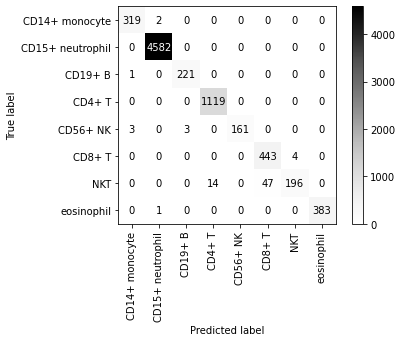

In [12]:
classification_complete_report(pipeline, 
                               df_features.loc[index_test,:], 
                               metadata.loc[index_test, "label"])

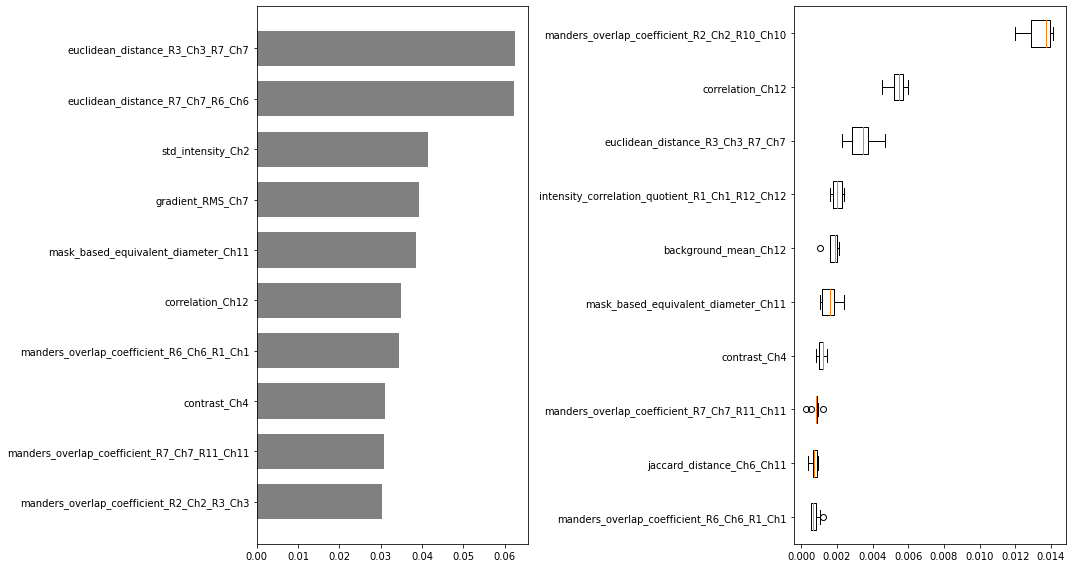

In [13]:

from sklearn.inspection import permutation_importance


number_of_important_features = min(len(selected_features), 10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(pipeline.steps[3][1].feature_importances_)[-1*number_of_important_features:]

tree_indices = np.arange(0, number_of_important_features) + 0.5

ax1.barh(tree_indices, 
         pipeline.steps[3][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(pipeline, 
                                df_features.loc[index_test,:],  
                                metadata.loc[index_test, "label"], n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-1*number_of_important_features:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()